In [ ]:
# подключение к Google диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/CNN_for_text') # смена рабочей директории

# CNN for text 

## Архитектура

<img src="img/architecture.png" width="700">

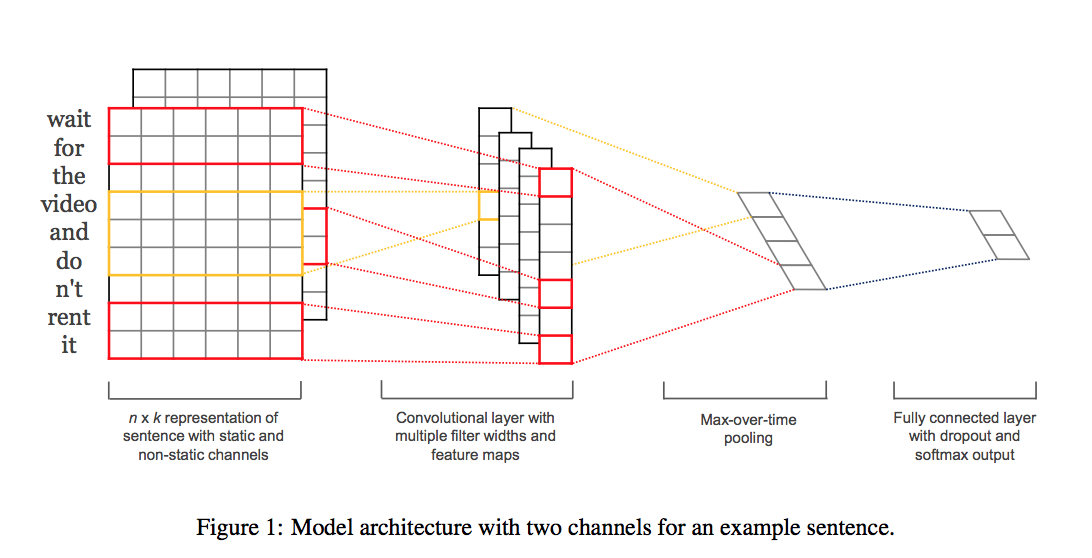

In [ ]:
from IPython.display import Image
Image('img/architecture.png', width=800)

Сначала предложения представляются в виде векторов слов и тогда эти слова конвертируются в 200 мерные вектора, предоставляя нам 2D представления для каждого предложения. Для получения word-embdding будет использоваться GloVe. В качестве оптимизатора - Adam. 

In [ ]:
# смотрим, что необходимые данные есть в папке input
print(os.listdir("./input"))

['glove-global-vectors-for-word-representation', 'movie-review-sentiment-analysis-kernels-only']


## Импорт неободимых библиотек

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.python.keras import regularizers

## Подготовка данных

Немного посмотрим на наши данные:

In [ ]:
df = pd.read_csv('./input/movie-review-sentiment-analysis-kernels-only/train.tsv', delimiter='\t')
df = df[['Phrase', 'Sentiment']]

pd.set_option('display.max_colwidth', -1)
df.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,Phrase,Sentiment
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,A series of escapades demonstrating the adage that what is good for the goose,2
2,A series,2


Мы видим, что `Phrase`, на которых мы хотим тренироваться не предобработанны. Поэтому немного очистим их.  
Сделаем по-простому, а именно превратить URL-адреса в метку `url`, удалим все, что не является буквенно-цифровым или пробелами. И переведем все в lowercase.

In [ ]:
def clean_str(in_str):
    in_str = str(in_str)
    # replace urls with 'url'
    in_str = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", in_str)
    in_str = re.sub(r'([^\s\w]|_)+', '', in_str)
    return in_str.strip().lower()


df['text'] = df['Phrase'].apply(clean_str) # теперь в поле текст - очищенный текст

Посмотрим на очищеные данные:

In [ ]:
df.head(3)

,Phrase,Sentiment,text
0,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story
1,A series of escapades demonstrating the adage that what is good for the goose,2,a series of escapades demonstrating the adage that what is good for the goose
2,A series,2,a series


Наши данные подразделяются на 5 различных классов: очень отрицательные, слегка отрицательные, нейтральные, слегка положительные и очень положительные.
К сожалению, наш набор данных не сбалансирован, поэтому нам нужно сбалансировать его самим.

In [ ]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4    9206 
0    7072 
Name: Sentiment, dtype: int64

Так как в наименьшем классе 7072 экземпляра, то для сбалансированной тренировочной выборки соберем по 7072 экземпляра из каждого класса.

In [ ]:
# в df_i запишем все предложения i-го класса
df_0 = df[df['Sentiment'] == 0].sample(frac=1)
df_1 = df[df['Sentiment'] == 1].sample(frac=1)
df_2 = df[df['Sentiment'] == 2].sample(frac=1)
df_3 = df[df['Sentiment'] == 3].sample(frac=1)
df_4 = df[df['Sentiment'] == 4].sample(frac=1)

sample_size = 7072

# Сбалансированные данные
data = pd.concat([df_0.head(sample_size), df_1.head(sample_size),
                  df_2.head(sample_size), df_3.head(sample_size), 
                  df_4.head(sample_size)]).sample(frac=1)

Далее требуется провести токенизацию, но прежде собрать информацию о предложениях в датасете:

In [ ]:
data['l'] = data['Phrase'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(data.l.mean()))
print("max length of sentence: " + str(data.l.max()))
print("std dev length of sentence: " + str(data.l.std()))

mean length of sentence: 9.110152714932127
max length of sentence: 52
std dev length of sentence: 8.024161658092133


Предложения не слишком длинные, поэтому мы можем использовать всю строку:

In [ ]:
sequence_length = 52

При постоении модели сохраним лишь 20000 самых частотных слов в корпусе, а остальные слова в словаре заменим на "unw"

In [ ]:
max_features = 20000 # число самых частых слов, которые оставляем в корпусе

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(data['Phrase'].values)

# заменяем слова в предложениях на числа, в соответсвии с словарем 20000 слов
X = tokenizer.texts_to_sequences(data['Phrase'].values)

# преобразуем все предложния в одинаковую длину 
X = pad_sequences(X, sequence_length)

# соберем категориальные признаки в y
y = pd.get_dummies(data['Sentiment']).values

# разбиваем данные на тренировочные и тестировачные (10% данных идут в тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("train set size " + str(len(X_train)))
print("test set size " + str(len(X_test)))

train set size 31824
test set size 3536


## Модель: binary classification c w2v и тренируемыми embeddings

Сначала нам требуется загрузить предобученную языковую модель 200D GloVe:

In [ ]:
embedding_dim = 200
embeddings_index = {}
f = open(os.path.join('./input/glove-global-vectors-for-word-representation', 'glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14139 unique tokens.


Теперь мы для каждого слова из tokenizer ищем его в нашей языковой модели. Если оно существует, то мы добавляем его в нашу всраиваемую модель, иначе мы назначаем случайный вектор из нормального распределения.

In [ ]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# сначала создадим матрицу из нулей - это наша матрица для встраивания
embedding_matrix = np.zeros((num_words, embedding_dim))

# для каждого слова из tokenixer ищем его в w2v модели
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # мы нашли слово в модели, добавим его в матрицу
        embedding_matrix[i] = embedding_vector
    else:
        # мы не нашли слово, добавим вместо него случайный вектор
        embedding_matrix[i] = np.random.randn(embedding_dim)

14140


Для бинарной классификации построим датасет SST2 состоящий из 2 классов.  
В SST2 очень негативные и немного отрицательные отзывы, объединенны в один класс, а немного положительным и положительным объединены в другой. (нейтральный пропускаем). Это дает нам двоичную классификацию, которую мы можем воспроизвести с нашими данными.

In [ ]:
sst2_data = pd.concat([df_0.head(sample_size), df_1.head(sample_size),
                       df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

def merge_sentiments(x):
    if x == 0 or x == 1:
        return 0
    else:
        return 1

sst2_data['Sentiment'] = sst2_data['Sentiment'].apply(merge_sentiments)

sst2_tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
sst2_tokenizer.fit_on_texts(sst2_data['Phrase'].values)

sst2_X = sst2_tokenizer.texts_to_sequences(sst2_data['Phrase'].values)
sst2_X = pad_sequences(sst2_X, sequence_length)

sst2_y = sst2_data['Sentiment'].values

sst2_X_train, sst2_X_test, sst2_y_train, sst2_y_test = train_test_split(sst2_X, sst2_y, test_size=0.1)

sst2_y

array([0, 0, 1, ..., 0, 0, 0])

## Подготовим свой датасет для unsuperised

In [ ]:
sst3_data = pd.concat([df_0.head(sample_size), df_1.head(sample_size),
                       df_3.head(sample_size), df_4.head(sample_size)]).sample(frac=1)

def merge_sentiments(x):
    if x == 0 or x == 1:
        return 1
    else:
        return 0

sst3_data['Sentiment'] = sst3_data['Sentiment'].apply(merge_sentiments)

sst3_norm = sst3_data[sst3_data['Sentiment'] == 0]
sst3_anomal = sst3_data[sst3_data['Sentiment'] == 1]

sst3_tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
sst3_tokenizer.fit_on_texts(sst3_norm['Phrase'].values)

sst3_X = sst3_tokenizer.texts_to_sequences(sst3_norm['Phrase'].values)
sst3_X = pad_sequences(sst3_X, sequence_length)

sst3_y = sst3_norm['Sentiment'].values


sst3_X_train, sst3_X_test, sst3_y_train, sst3_y_test = train_test_split(sst3_X, sst3_y, test_size=0.1)

sst3_tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
sst3_tokenizer.fit_on_texts(sst3_data['Phrase'].values)
sst3_XX = sst3_tokenizer.texts_to_sequences(sst3_data['Phrase'].values)
sst3_XX = pad_sequences(sst3_XX, sequence_length)
sst3_Xan = sst3_tokenizer.texts_to_sequences(sst3_anomal['Phrase'].values)
sst3_Xan = pad_sequences(sst3_Xan, sequence_length)
sst3_yy = sst3_data['Sentiment'].values

## Cвоя функция активации для последнего слоя rbf

In [ ]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = (1 * self.gamma * l2) #(-1 * self.gamma * l2)
        # res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

## Своя функция потерь

In [ ]:
def distance(y_true, y_pred):
    return y_pred

## Задаем слои модели:

In [ ]:
num_filters = 100

inputs_4 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_4 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs_4)

reshape_4 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_4)

conv_0_4 = Conv2D(num_filters, kernel_size=(3, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_1_4 = Conv2D(num_filters, kernel_size=(4, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)
conv_2_4 = Conv2D(num_filters, kernel_size=(5, embedding_dim), padding='valid', kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_4)

maxpool_0_4 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_4)
maxpool_1_4 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_4)
maxpool_2_4 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_4)

concatenated_tensor_4 = Concatenate(axis=1)([maxpool_0_4, maxpool_1_4, maxpool_2_4])
flatten_4 = Flatten()(concatenated_tensor_4)

dropout_4 = Dropout(0.5)(flatten_4)
# note the different activation
output_4 = RBFLayer(units=1, gamma=1)(dropout_4)

In [ ]:
model_4 = Model(inputs=inputs_4, outputs=output_4)

# используем binary_crossentropy
model_4.compile(loss=distance, optimizer='adam', metrics=['accuracy'])
print(model_4.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 52, 200)      2828000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 52, 200, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 1, 100)   60100       reshape[0][0]                    
_______________________________________________________________________________________

In [ ]:
batch_size = 32
history_4 = model_4.fit(sst3_X_train, sst3_y_train, epochs=30, batch_size=batch_size, verbose=1, validation_split=0.2)

Epoch 1/30
319/319 [==============================] - 10s 30ms/step - loss: 210.4267 - accuracy: 0.6993 - val_loss: 0.3567 - val_accuracy: 1.0000
Epoch 2/30
319/319 [==============================] - 9s 29ms/step - loss: 0.0722 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 3/30
319/319 [==============================] - 9s 30ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.9690e-04 - val_accuracy: 1.0000
Epoch 4/30
319/319 [==============================] - 9s 30ms/step - loss: 5.4558e-05 - accuracy: 1.0000 - val_loss: 4.8224e-06 - val_accuracy: 1.0000
Epoch 5/30
319/319 [==============================] - 9s 30ms/step - loss: 1.1274e-06 - accuracy: 1.0000 - val_loss: 5.1219e-08 - val_accuracy: 1.0000
Epoch 6/30
319/319 [==============================] - 10s 30ms/step - loss: 9.8174e-09 - accuracy: 1.0000 - val_loss: 1.8407e-10 - val_accuracy: 1.0000
Epoch 7/30
319/319 [==============================] - 10s 30ms/step - loss: 2.8910e-11 - accuracy: 1.0000 - va

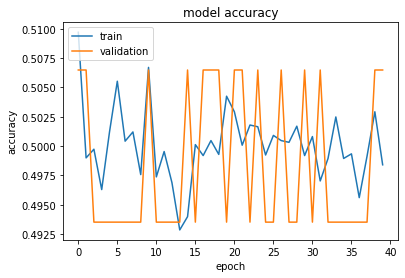

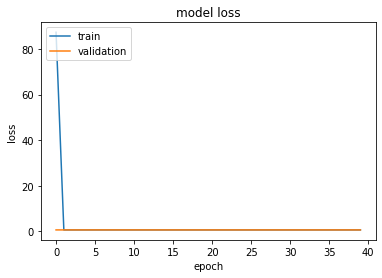

In [ ]:
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_hat_4 = model_4.predict(sst3_X)
print(np.mean(y_hat_4))
y_hat_an = model_4.predict(sst3_Xan)
print(np.mean(y_hat_4))
y_hat_4 = model_4.predict(sst3_XX)
print(np.mean(y_hat_4))


# accuracy_score(sst3_yy, list(map(lambda v: v > 0.001, y_hat_4)))

0.0
0.0
0.0


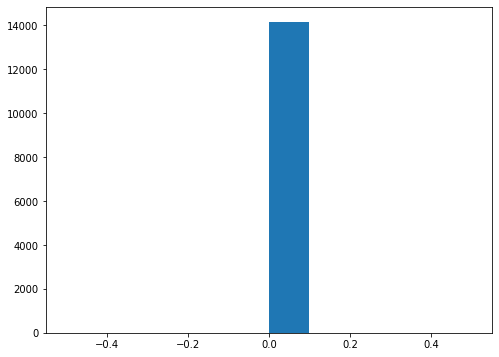

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(8, 6))
pyplot.hist(y_hat_an);

In [ ]:
confusion_matrix(sst2_y_test, list(map(lambda v: v > 0.5, y_hat_4)))

array([[1121,  306],
       [ 140, 1262]])